In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
nltk.download('vader_lexicon')
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from operator import itemgetter
import random
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    #print(coherence_values)
    #x = range(start, stop, step)
    #plt.plot(x, coherence_values)
    #plt.xlabel("Number of Topics")
    #plt.ylabel("Coherence score")
    #plt.legend(("coherence_values"), loc='best')
    #plt.show()
    c = coherence_values.index(max(coherence_values))
    return start + c

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
data = pd.read_json("15ClusterCampaign.json")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
text = data["text"].tolist()
scores = list()
positive = list()
negative = list()
neut = list()
for t in text:
    scores.append(vader.polarity_scores(t)['compound'])
    positive.append(vader.polarity_scores(t)['pos'])
    negative.append(vader.polarity_scores(t)['neg'])
    neut.append(vader.polarity_scores(t)['neu'])
print(scores[0])
print(positive[0])
print(negative[0])
print(neut[0])


0.7494
0.285
0.0
0.715


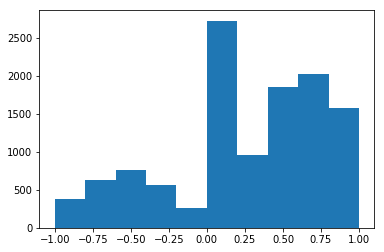

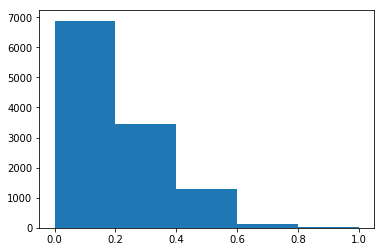

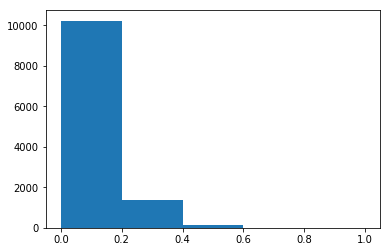

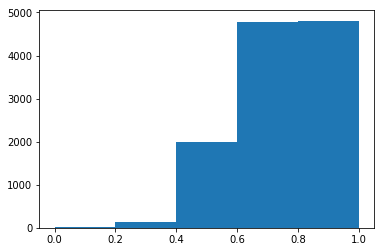

In [3]:
plt.hist(scores,bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
plt.show()

plt.hist(positive,bins=[0,0.2,0.4,0.6,0.8,1])
plt.show()

plt.hist(negative,bins=[0,0.2,0.4,0.6,0.8,1])
plt.show()

plt.hist(neut,bins=[0,0.2,0.4,0.6,0.8,1])
plt.show()

In [4]:
data["vaderScore"] = scores
data.drop(["in_reply_to_user_id_str","is_retweet","text","modded_text","modded1","year","date"],axis=1,inplace=True)
data.corr()

,favorite_count,retweet_count,month,hour,week_year,labels,vaderScore
favorite_count,1.000000,0.929920,0.250773,0.060894,0.239500,0.004576,-0.063807
retweet_count,0.929920,1.000000,0.242095,0.066795,0.231188,0.014018,-0.087421
month,0.250773,0.242095,1.000000,0.071850,0.976724,-0.006264,-0.043811
hour,0.060894,0.066795,0.071850,1.000000,0.072169,0.034919,-0.042753
week_year,0.239500,0.231188,0.976724,0.072169,1.000000,-0.008115,-0.043288
labels,0.004576,0.014018,-0.006264,0.034919,-0.008115,1.000000,-0.075277
vaderScore,-0.063807,-0.087421,-0.043811,-0.042753,-0.043288,-0.075277,1.000000


0.23019075730471084


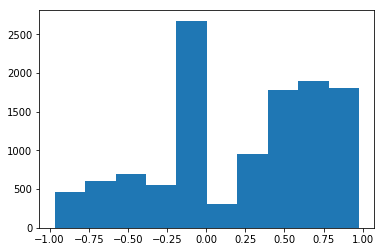

In [5]:
plt.hist(data["vaderScore"])
print(data["vaderScore"].mean())

In [6]:
x1 = data[data["labels"] == 2]
print(len(x1))
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(),
                      columns=feat_names)
    return(df)
  

stemmed_words = pd.Series(' '.join(data['modded1_stemmed']).split()).value_counts()
stemmed_words = stemmed_words[stemmed_words < 2000]
stemmed_words = stemmed_words[stemmed_words > 3]
x1['m'] = data['modded1_stemmed'].apply(lambda x: " ".join(x for x in x.split() if x in stemmed_words))

corpus = x1["m"].tolist()

# instantiate the vectorizer object
cvec = TfidfVectorizer()

# convert the documents into a document-term matrix
wm = cvec.fit_transform(corpus)

# retrieve the terms found in the corpora
tokens = cvec.get_feature_names()

# create a dataframe from the matrix
c = wm2df(wm, tokens)

331


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
stemmed_words

great                    1652
thank                    1381
amp                       905
america                   803
make                      772
trump2016                 768
presid                    763
donald                    755
get                       671
hillari                   634
peopl                     617
vote                      593
run                       588
go                        584
makeamericagreatagain     548
need                      533
new                       531
poll                      525
time                      477
watch                     469
would                     469
like                      468
love                      454
countri                   452
us                        419
one                       402
show                      379
win                       379
clinton                   378
want                      378
                         ... 
column                      4
htt                         4
houston   

(array([2.875e+03, 6.900e+01, 2.000e+01, 9.000e+00, 6.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([   4. ,  168.8,  333.6,  498.4,  663.2,  828. ,  992.8, 1157.6,
        1322.4, 1487.2, 1652. ]),
 <a list of 10 Patch objects>)

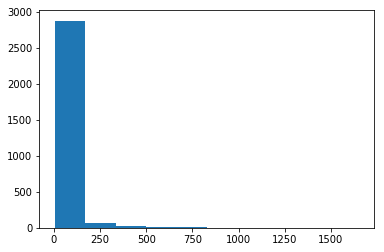

In [8]:
plt.hist(stemmed_words)

In [9]:
x1.reset_index(inplace=True,drop=True)
res = pd.concat([x1,c], axis=1)
#hour peggiora di brutto e monht alza di tanto sse!!!
res1 = res.drop(["week_year","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["week_year","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 
res

,favorite_count,retweet_count,month,hour,week_year,noTags_punct,modded1_stemmed,labels,vaderScore,m,...,wrote,wsj,ye,year,yesterday,yet,york,your,youv,zero
0,45,19,1,0,1,llankers donaldtrump its a shame the left try ...,llanker donaldtrump shame left tri hard ...,2,0.1093,donaldtrump shame left tri hard tear could gre...,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
1,18,8,1,21,1,_snurk realdonaldtrump is so awesome man of na...,_snurk realdonaldtrump awesom man natl u...,2,0.8892,_snurk awesom man natl need leader rule elect ...,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
2,43,15,1,3,1,aanders07 realdonaldtrump i am actually excite...,aanders07 realdonaldtrump actual excit we...,2,-0.2741,actual excit weekend watch celebr apprentic ca...,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
3,92,41,1,3,1,llluminatedones watch celebapprentice tomorrow...,llluminatedon watch celebapprentic tomorro...,2,0.0000,watch celebapprentic tomorrow 9pm et nbc said ...,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
4,39,10,1,3,1,yurdreamwoman apprenticenbc realdonaldtrump wo...,yurdreamwoman apprenticenbc realdonaldtrump...,2,0.4019,apprenticenbc would great obama show fire,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
5,13,3,1,3,1,sistertrue realdonaldtrump cant wait love this...,sistertru realdonaldtrump cant wait love ...,2,-0.2640,cant wait love show help realiz mani thing,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
6,26,14,1,3,1,mattlytle realdonaldtrump so a new celebrity a...,mattlytl realdonaldtrump new celebr appre...,2,0.5319,new celebr apprentic sunday monday night ye,...,0.0,0.0,0.401496,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
7,400,187,1,15,1,everyone is asking me to cover the apprentice ...,everyon ask cover apprentic live twitter...,2,0.7290,everyon ask cover apprentic live twitter tonig...,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
8,51,25,1,2,2,apprenticenbc nobody wants to be the first one...,apprenticenbc nobodi want first one fire...,2,-0.7796,apprenticenbc nobodi want first one fire isnt ...,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
9,28,5,1,2,2,jakekrippner realdonaldtrump so who should wi...,jakekrippn realdonaldtrump win favorit sh...,2,0.6204,win favorit shawnjohnson,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0


In [10]:
res1.columns

Index(['month', 'vaderScore', '100', '11', '1st', '20', '200000', '2015',
       '2016', '20th',
       ...
       'wrote', 'wsj', 'ye', 'year', 'yesterday', 'yet', 'york', 'your',
       'youv', 'zero'],
      dtype='object', length=1123)

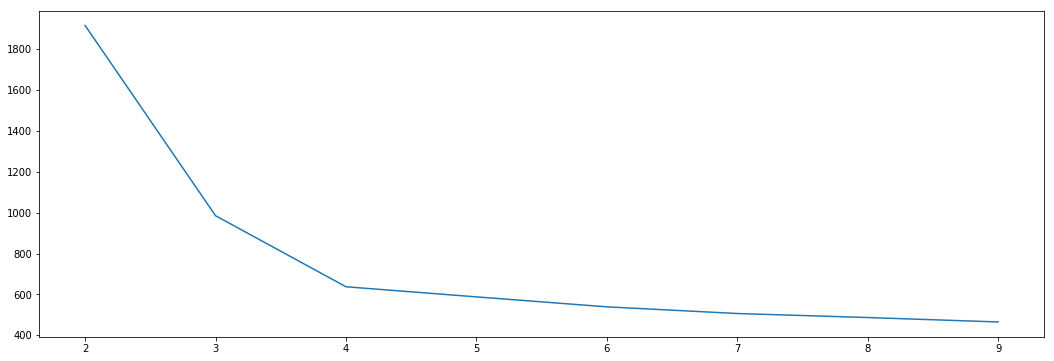

CPU times: user 10.3 s, sys: 23.7 s, total: 34.1 s
Wall time: 1.67 s


In [16]:
%%time
sse_list = list()
max_k = 10
plt.figure(figsize=(18,6))
for k in range(2,max_k):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(res1)
    sse = kmeans.inertia_
    sse_list.append(sse)
plt.plot(range(2,max_k), sse_list)
plt.show()

In [13]:
#6 per il label 1 (15 cluster)
true_k =4
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=10)
model.fit(res1)
print(model.inertia_)
print
labels = model.labels_
res1["labels"] = labels
dataWithText["labels"] = labels
d = silhouette_score(res1, labels,metric='euclidean')
print(d)

637.6555644235593
0.5000704487894709


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [15]:
#per descrivere i cluster prendi i valori con tfidf più alto
g = res1.drop(['month',"vaderScore"],axis=1)

for cluster in g["labels"].unique():
    g1 = g[g["labels"] == cluster]
    d1 = dataWithText[dataWithText["labels"] == cluster]
    meanTf = []
    for column in g1.columns:
        if column != "labels":
            m = g1[column].mean()
            meanTf.append([column,m])
    
    meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
    print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")
    el = random.randint(g1.index[0],g1.index[len(g1)-1])
    el1 = random.randint(g1.index[0],g1.index[len(g1)-1])
    el2 = random.randint(g1.index[0],g1.index[len(g1)-1])
    #print(res.iloc[el]["noTags_punct"] + "\n")
    #print(res.iloc[el1]["noTags_punct"]+ "\n")
    #print(res.iloc[el2]["noTags_punct"]+ "\n")
    
    tokenizer = RegexpTokenizer(r'\w+')

    counted = pd.Series(' '.join(d1['m']).split()).value_counts()
    #counted = counted[5:] #5 per label 1 
    counted = counted[counted > 5]
    d1['m'] = d1['m'].apply(lambda x: " ".join(x for x in x.split() if x in counted))

    corpus = d1["m"].tolist()
    #print(len(corpus))
    corp = []
    for string in corpus:
        tokens = tokenizer.tokenize(string)
        corp.append(tokens)

    dictionary = corpora.Dictionary(corp)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in corp]
    
    start,stop,step=1,10,1
    nTopics = plot_graph(corp,start,stop,step)
    print("NUMBER OF TOPICS: ", nTopics)
    words = 7
    lsamodel = LsiModel(doc_term_matrix, num_topics=nTopics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics = -1,num_words = words))

cluster  3  lunghezza  103 :
 [['would', 0.028209157124140096], ['show', 0.02797836228121739], ['apprenticenbc', 0.026402868393902473], ['love', 0.026173600534911672], ['apprentic', 0.02616062997209667]]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


NUMBER OF TOPICS:  8
[(0, '0.469*"would" + 0.254*"show" + 0.244*"apprentic" + 0.240*"hillari" + 0.232*"good" + 0.222*"run" + 0.221*"love"'), (1, '0.369*"would" + -0.313*"apprentic" + 0.298*"ted" + -0.288*"back" + -0.286*"love" + 0.275*"presid" + 0.253*"hillari"'), (2, '-0.538*"ted" + -0.517*"cruz" + 0.399*"presid" + 0.333*"would" + -0.232*"one" + -0.229*"much" + -0.129*"peopl"'), (3, '0.435*"apprenticenbc" + 0.411*"one" + 0.352*"celebapprentic" + 0.269*"last" + -0.245*"back" + 0.224*"fire" + 0.209*"love"'), (4, '0.477*"one" + -0.391*"love" + 0.337*"good" + 0.313*"last" + -0.264*"watch" + 0.251*"peopl" + 0.243*"show"'), (5, '-0.493*"presid" + -0.350*"get" + 0.328*"would" + -0.328*"mani" + -0.255*"win" + 0.246*"hillari" + -0.242*"much"'), (6, '0.391*"want" + 0.337*"run" + -0.337*"presid" + 0.290*"show" + 0.280*"fire" + 0.250*"apprenticenbc" + 0.246*"get"'), (7, '-0.465*"want" + -0.373*"apprentic" + 0.367*"show" + -0.298*"run" + 0.253*"great" + 0.250*"mani" + 0.205*"would"')]
cluster  0  

In [ ]:
stemmed_words

In [ ]:
dictionary = corpora.Dictionary(corp)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in corp]
doc_term_matrix